# Problem Statement

The following map shows the 6 intersections at which automatic traffic monitoring devices might be installed. A station at any particular node can monitor all the road links meeting that intersection. Numbers next to nodes reflect the monthly cost (in thousands of dollars) of operating a station at that location. This problem is known as the set covering problem in combinatorial optimization.

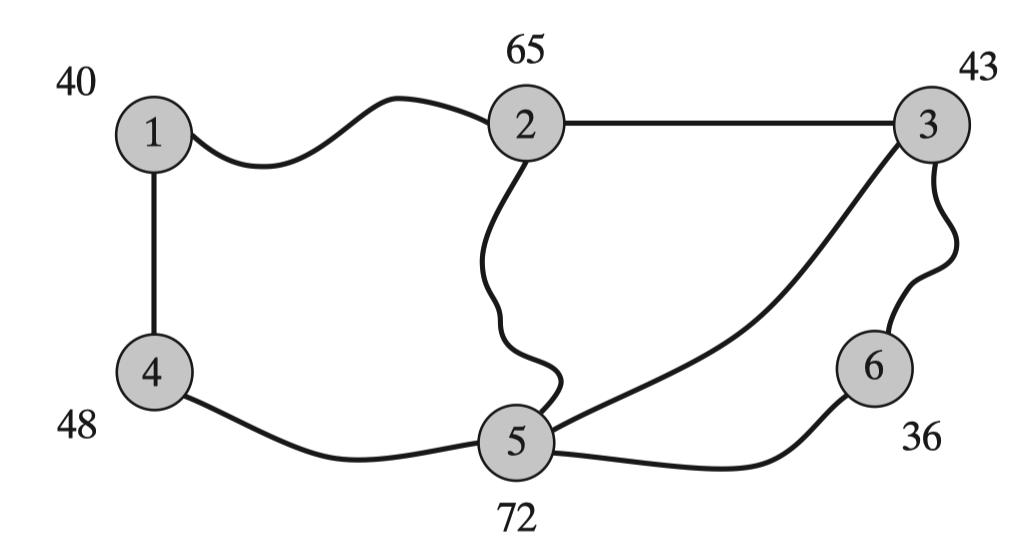


The objective this time is to obtain an ILP minimizing the number of uncovered road links while using at most 2 stations.

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import shutil
import sys
import os.path
from pyomo.environ import *

import pyomo.environ as pe
import pyomo.opt as po

#### Defining Data

In [2]:
nodes = set(range(1, 7))

In [3]:
connections = {
    (1,2):1,
    (1,4):1,
    (2,1):1,
    (2,3):1,
    (2,5):1,
    (3,2):1,
    (3,5):1,
    (3,6):1,
    (4,1):1,
    (4,5):1,
    (5,2):1,
    (5,3):1,
    (5,4):1,
    (5,6):1,
    (6,3):1,
    (6,5):1,
}   

## Model

The objective of minimizing the number of uncovered road links is equivalent to maximizing the number of road links that can be covered. Let the decision variable representing the selection of edge $(n,v) \in E$ be $Y_{nv}$. 
Then, the objective can be written as: 
$$ \text{Max} \; \sum_{ (n,v) \in E} \frac{Y_{nv}}{2}  $$

(Note:  We divide by 2 since $ Y_{nv} = Y_{vn}$, as because selection of at least one node of an edge would result in the edge being covered)

Further, the edge selection and hence the objective would be implicitly governed by the node selection decision. Representing the node selection decision with $x_n \; \forall \; n \in N$, the logic for edge selection is written as:

$$ Y_{nv} \Leftrightarrow (x_n \lor x_v)\ $$

The logic facilitates the selection of the edge whenever either node of an edge is chosen. The above logic can be broken down into the following linear constraints:

\begin{aligned}
    & Y_{nv} \leq X_n + X_v \\
    & Y_{nv} \geq X_n \\
    & Y_{nv} \geq X_v \\
\end{aligned}
\
Subject to:
$$ \sum_{n \in N} x_n \leq 2 $$
$$ x_n \in \{0, 1\} \;\; \forall n \in N $$

The knowledge of node selection would yield the set of uncovered edges and thus their count.

## Implement

In [4]:
m = pe.ConcreteModel()

#### Initializing Sets

In [5]:
m.nodes = pe.Set(initialize=nodes)                       # Ignore if any warnings appear
adj = list(connections.keys())                           # Taking keys of connections and converting to list
m.A = pe.Set(within=m.nodes*m.nodes, initialize=adj)     # Adjacency Matrix for Edges

source (type: set).  This WILL potentially lead to nondeterministic behavior
in Pyomo


#### Initializing Parameters

In [6]:
m.connections = pe.Param(m.A,initialize=connections)  

#### Initializing Variables

In [7]:
m.X = pe.Var(m.nodes, domain=pe.Binary) 
m.Y = pe.Var(m.A, domain=pe.Binary) 

#### Defining Objective

In [8]:
def covered_links(m):
    return  sum(m.Y[i,j] for (i,j) in m.A)/2
m.obj = pe.Objective(sense=pe.maximize,rule = covered_links)


#### Defining Constraints

In [9]:
def each_edge_rule(m, i, j):
    return m.Y[i,j] <= m.X[i] + m.X[j]
m.edge_constraint = Constraint(m.A, rule=each_edge_rule)

def each_node_rule_a(m, i, j):
    return m.Y[i,j] >= m.X[i]
m.node_constraint_a = Constraint(m.A, rule=each_node_rule_a)

def each_node_rule_b(m, i, j):
    return m.Y[i,j] >= m.X[j]
m.node_constraint_b = Constraint(m.A, rule=each_node_rule_b)

In [10]:
def maxstation_rule(m):
    return sum(m.X[i] for i in m.nodes) <= 2

m.nodes_constraint =  pe.Constraint(rule=maxstation_rule)

## Solve and Postprocess

In [11]:
solver = po.SolverFactory('gurobi')
results = solver.solve(m, tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-19
Read LP format model from file /var/folders/ch/190yzmt56zsfp9c_z9g_fcjc0000gn/T/tmpm3_7w4cl.pyomo.lp
Reading time = 0.01 seconds
x1: 49 rows, 22 columns, 118 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 21.6.0 21G1974)

CPU model: Intel(R) Core(TM) i5-5250U CPU @ 1.60GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 49 rows, 22 columns and 118 nonzeros
Model fingerprint: 0xacdf386b
Variable types: 0 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 40 rows and 8 columns
Presolve time: 0.02s
Presolved: 9 rows, 14 columns, 30 nonzeros
Variable types: 0 continuous, 14 integer (14 binary)
Found heuristic solut

In [12]:
#print("Objective Value (no physical sense): ",pe.value(m.obj))
print("Number of edges covered ",pe.value(m.obj))

Number of edges covered  6.0


In [13]:
# Finding the nodes which are being selected
selected_nodes = []
for i in m.nodes:
    # print(i)
    if pe.value(m.X[i])==1:
        selected_nodes.append(i)
print("Selected nodes:",selected_nodes) 

# Finding the links which are not being covered
uncovered_links = []
for k in connections.keys():
    if not (k[0] in selected_nodes or k[1] in selected_nodes):
        uncovered_links.append(k)

# Counting the number of uncovered links
uncovered_links = set(uncovered_links)
uncovered_links_final = set(uncovered_links)
for i in uncovered_links:
    if tuple(reversed(i)) in uncovered_links_final:
        uncovered_links_final.remove(i)
print("Uncovered links:",uncovered_links_final, "\nCount of uncovered links:",len(uncovered_links_final))

Selected nodes: [3, 5]
Uncovered links: {(2, 1), (1, 4)} 
Count of uncovered links: 2
